In [0]:
import numpy as np
import torch
import torchvision
import pickle
import torch.nn.functional as F
import matplotlib.pyplot  as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
with open('drive/My Drive/Colab Notebooks/colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)

In [0]:
train = data['train']
test = data['test']

In [5]:
print("Count train samples: ", train.shape[0])
print("Count test samples: ", test.shape[0])
print("Shape of image (H, W, C): ", train[0].shape)

Count train samples:  60000
Count test samples:  10000
Shape of image (H, W, C):  (28, 28, 3)


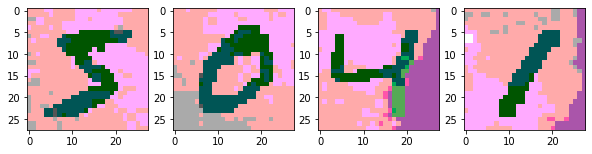

In [6]:
fig = plt.figure(figsize=(10, 10))
def show_image(i, image): 
  print_image =  image * (255 / 3)
  fig.add_subplot(1, 4, i+1)
  plt.imshow(print_image.astype(int))
  

for i in range(0, 4):
  show_image(i, train[i])
plt.show()

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, target, transform=None):
      self.target = torch.from_numpy(target).permute(0, 3, 1, 2)
      self.transform = transform
      
  def __getitem__(self, index):
      y = self.target[index]
      
      if self.transform:
          y = self.transform(y)
          
      return y
  
  def __len__(self):
      return len(self.target)

In [0]:
BATCHSIZE = 100

In [0]:
train_ds = MyDataset(train)
test_ds = MyDataset(test)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCHSIZE)
testloader = torch.utils.data.DataLoader(test_ds, batch_size=BATCHSIZE)

In [10]:
dataiter = iter(trainloader)
labels = dataiter.next()
print("Tensor shape: ", labels.shape)

Tensor shape:  torch.Size([100, 3, 28, 28])


## Masking

- ConvLayer 7x7 needs Mask A

- The Convlayers in the residual Blocks need the Mask B 


### Example for 3x3 Filter
- Mask A:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 0 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

- Mask B:
$\left( \begin{array}{rrr}
1 & 1 & 1 \\
1 & 1 & 0 \\
0 & 0 & 0 \\
\end{array}\right) $

In [0]:
# Quelle: https://www.codeproject.com/Articles/5061271/PixelCNN-in-Autoregressive-Models
class MaskedConv2d(torch.nn.Conv2d):
  def __init__(self, mask_type, *args, **kwargs):
    super().__init__(*args, **kwargs)
    assert mask_type in ('A', 'B')
    self.register_buffer('mask', self.weight.data.clone())
    _, _, fH, fW = self.weight.size()
    
    self.mask.fill_(1)
    if (mask_type == 'B'): 
      self.mask[:, :, fH // 2, fW // 2 + 1:] = 0
    else:
      self.mask[:, :, fH // 2, fW // 2:] = 0
    
    self.mask[:, :, fH // 2 + 1:] = 0

  def forward(self, x):
    self.weight.data *= self.mask
    return super(MaskedConv2d, self).forward(x)

In [0]:
class ResBlock(torch.nn.Module):

  def __init__(self, channels=64):
    super(ResBlock, self).__init__()
    self.channels=channels

    self.network = torch.nn.Sequential(
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels*2,self.channels, 1, stride=1, padding=0), 
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        MaskedConv2d('B',self.channels, self.channels, 3, stride=1, padding=1),
        torch.nn.BatchNorm2d(self.channels), 
        torch.nn.ReLU(),
        torch.nn.Conv2d(self.channels,self.channels*2, 1, stride=1, padding=0),
        torch.nn.BatchNorm2d(2*self.channels)
      )
    
  def forward(self, x):
    out = self.network(x)
    return x + out


In [0]:
# https://github.com/karpathy/pytorch-made/blob/master/made.py 
class MaskedLinear(torch.nn.Linear):
    """ same as Linear except has a configurable mask on the weights """
    
    def __init__(self, in_features, out_features, bias=True):
      super().__init__(in_features, out_features, bias)        
      self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
      self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, x):
      x = x.reshape(-1, self.mask.shape[1])
      return F.linear(x, self.mask * self.weight, self.bias)


In [0]:
class MADE(torch.nn.Module):

  def __init__(self):
    super(MADE, self).__init__()

    self.in_features = 28*28*3*4
    self.out_features = 256
    self.num_masks = 3

    self.layers = torch.nn.Sequential(
      MaskedLinear(in_features=self.in_features, out_features=self.out_features),
      torch.nn.BatchNorm1d(self.out_features), 
      torch.nn.ReLU(),
      MaskedLinear( in_features=self.out_features, out_features=self.out_features),
      torch.nn.BatchNorm1d(256), 
      torch.nn.ReLU(),
      MaskedLinear(in_features=self.out_features, out_features=self.in_features)
    )
    self.seed = 0

    self.m = {}
    self.update_mask()
  
  def update_mask(self):
    rnd_state = np.random.RandomState(self.seed)
    L = self.num_masks
    self.seed = (self.seed + 1) % self.num_masks

    self.m[-1] = rnd_state.permutation(self.in_features)

    for i in range(L):
      if i == (L-1):
        self.m[i] = rnd_state.randint(self.m[i-1].min(), self.in_features, size=self.in_features)
      else:
        self.m[i] = rnd_state.randint(self.m[i-1].min(), self.in_features, size=self.out_features)

    masks = [self.m[l-1][:,None] <= self.m[l][None,:] for l in range(L)]
    masks.append(self.m[L-1][:,None] < self.m[-1][None,:])


    layers = [l for l in self.layers.modules() if isinstance(l, MaskedLinear)]
    
    for l,m in zip(layers, masks):
      l.set_mask(m)


  def forward(self, x):
    batch_size, channels, classes, h, w = x.shape
    out = self.layers(x).reshape(-1, 4, 3, 28, 28)
    return out

In [0]:
class PixelCNN(torch.nn.Module):
    
  def __init__(self, channels=16, res_blocks=12): 
    super(PixelCNN,self).__init__()
    layers = []
    layers.append(MaskedConv2d("A", 3, channels*2, 7, padding=3))

    for i in range(res_blocks):
      layers.append(ResBlock(channels))

    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(channels*2, 1024, 1, 1, 0))
    layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Conv2d(1024, 3*4, 1, 1, 0))

    self.network = torch.nn.Sequential(*layers)
    self.made = MADE().to(device)
   
  def forward(self, x):
    batch_size = x.shape[0]
    pixel_cnn = self.network(x).view(batch_size, 4, 3, 28, 28)
    self.made.update_mask()
    out = self.made(pixel_cnn)
    return out

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
pixelCNN = PixelCNN(128).to(device)

if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  pixelCNN = torch.nn.DataParallel(pixelCNN)

In [18]:
device

device(type='cuda', index=0)

In [19]:
torch.cuda.device_count()

1

In [0]:
optimizer = torch.optim.Adam(pixelCNN.parameters(),lr=1e-3, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [0]:
def sample_image(batch_size=4):
  image = torch.Tensor(np.random.choice(4, size=(batch_size, 3, 28, 28))).type(torch.FloatTensor).cuda()
  
   
  for i in range(28):
    for j in range(28):
      for k in range(3):
        with torch.no_grad():
          out = pixelCNN(image).permute(0, 2, 3, 4, 1)

        p = torch.nn.functional.softmax(out[:, k, i, j], dim=1).data
        pixel = torch.multinomial(p, 1)
        image[:, k, i, j] = pixel.view(-1)
  

  image = image.permute(0,2,3,1).cpu().detach().numpy().astype(int)  
  image = image * (255 / 3)

  if batch_size==4:
    fig = plt.figure(figsize=(10, 10))
    image = image.reshape(4, 28, 28, 3)
    for i in range(0, 4):
      fig.add_subplot(1, 4, i+1)
      print_image = image[i,:,:,:]
      plt.imshow(print_image.astype(int))
    plt.show()
  else:
    fig, axs = plt.subplots(20, 5, figsize=(20, 50))
    count = 0

    for i in range(20):
      for j in range(5):
        temp_image = image[count,:,:,:].astype(int)
        count += 1
        axs[i][j].imshow(temp_image.reshape(28,28,3))

    plt.show()
  return image

epoch: 0 i: 99 loss: 0.5820346474647522 val loss: 0.5894376039505005
epoch: 0 i: 199 loss: 0.5504593253135681 val loss: 0.508030891418457
epoch: 0 i: 299 loss: 0.4600432813167572 val loss: 0.4619426429271698
epoch: 0 i: 399 loss: 0.432562917470932 val loss: 0.446222722530365
epoch: 0 i: 499 loss: 0.4175458252429962 val loss: 0.4209621846675873
epoch: 0 i: 599 loss: 0.4347416162490845 val loss: 0.4112682640552521


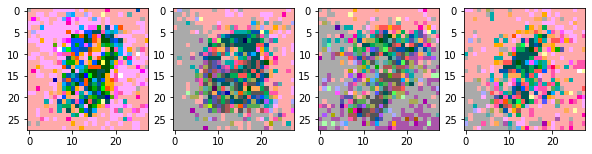

epoch: 1 i: 99 loss: 0.3961959779262543 val loss: 0.40236830711364746
epoch: 1 i: 199 loss: 0.43348559737205505 val loss: 0.38771384954452515
epoch: 1 i: 299 loss: 0.3762507438659668 val loss: 0.3781167268753052
epoch: 1 i: 399 loss: 0.368403822183609 val loss: 0.38023480772972107
epoch: 1 i: 499 loss: 0.36624273657798767 val loss: 0.3681715428829193
epoch: 1 i: 599 loss: 0.3939410150051117 val loss: 0.36770859360694885


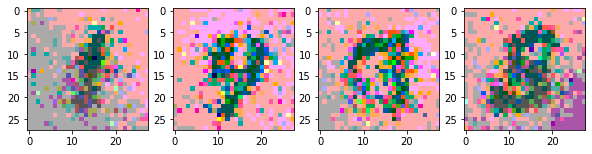

epoch: 2 i: 99 loss: 0.35748785734176636 val loss: 0.3627050817012787
epoch: 2 i: 199 loss: 0.39798980951309204 val loss: 0.3530808687210083
epoch: 2 i: 299 loss: 0.34435975551605225 val loss: 0.34829437732696533
epoch: 2 i: 399 loss: 0.3397779166698456 val loss: 0.3525815010070801
epoch: 2 i: 499 loss: 0.34218379855155945 val loss: 0.34329918026924133
epoch: 2 i: 599 loss: 0.3734248876571655 val loss: 0.3453395664691925


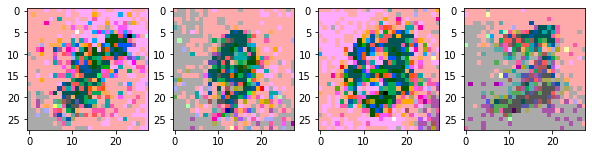

epoch: 3 i: 99 loss: 0.33747273683547974 val loss: 0.3420606851577759
epoch: 3 i: 199 loss: 0.37819981575012207 val loss: 0.3349405527114868
epoch: 3 i: 299 loss: 0.32665205001831055 val loss: 0.3311905860900879
epoch: 3 i: 399 loss: 0.3242270350456238 val loss: 0.3369688391685486
epoch: 3 i: 499 loss: 0.3278830647468567 val loss: 0.3288317322731018
epoch: 3 i: 599 loss: 0.3615116775035858 val loss: 0.332321435213089


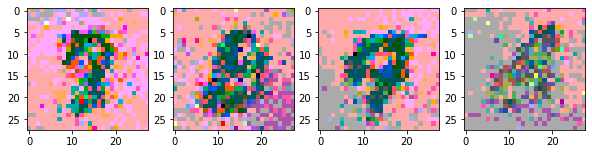

epoch: 4 i: 99 loss: 0.3254910111427307 val loss: 0.33001312613487244
epoch: 4 i: 199 loss: 0.36567404866218567 val loss: 0.3240986168384552
epoch: 4 i: 299 loss: 0.31586378812789917 val loss: 0.32031136751174927
epoch: 4 i: 399 loss: 0.3145528733730316 val loss: 0.3267305791378021
epoch: 4 i: 499 loss: 0.31895703077316284 val loss: 0.3195573389530182
epoch: 4 i: 599 loss: 0.353494793176651 val loss: 0.3243829011917114


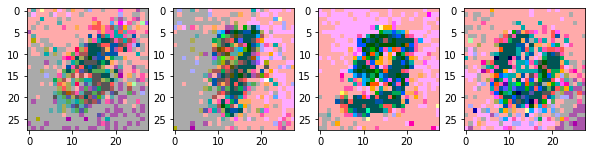

epoch: 5 i: 99 loss: 0.3180132806301117 val loss: 0.321970134973526
epoch: 5 i: 199 loss: 0.3576948940753937 val loss: 0.3166157603263855
epoch: 5 i: 299 loss: 0.30880656838417053 val loss: 0.31323906779289246
epoch: 5 i: 399 loss: 0.3081633746623993 val loss: 0.3202170729637146
epoch: 5 i: 499 loss: 0.3130088150501251 val loss: 0.3132045269012451
epoch: 5 i: 599 loss: 0.3482384979724884 val loss: 0.31912824511528015


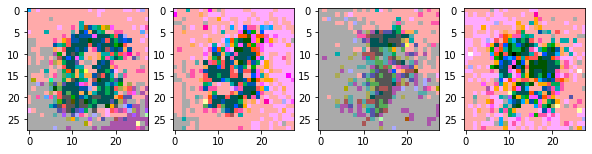

epoch: 6 i: 99 loss: 0.3127342760562897 val loss: 0.31621429324150085
epoch: 6 i: 199 loss: 0.3525506556034088 val loss: 0.3115008771419525
epoch: 6 i: 299 loss: 0.30388307571411133 val loss: 0.3089999556541443
epoch: 6 i: 399 loss: 0.30370646715164185 val loss: 0.3159414529800415
epoch: 6 i: 499 loss: 0.3089573383331299 val loss: 0.3088952600955963
epoch: 6 i: 599 loss: 0.34505558013916016 val loss: 0.3157079815864563


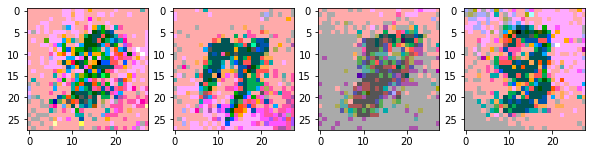

epoch: 7 i: 99 loss: 0.30959615111351013 val loss: 0.3126373291015625
epoch: 7 i: 199 loss: 0.3492041826248169 val loss: 0.3082289695739746
epoch: 7 i: 299 loss: 0.3007764220237732 val loss: 0.3060871660709381
epoch: 7 i: 399 loss: 0.3005366921424866 val loss: 0.31309592723846436
epoch: 7 i: 499 loss: 0.3061613440513611 val loss: 0.30622249841690063
epoch: 7 i: 599 loss: 0.3426656723022461 val loss: 0.31335341930389404


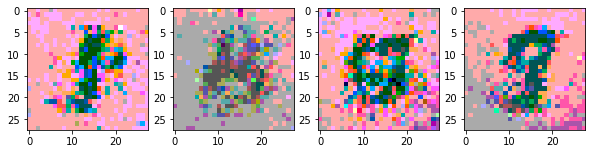

epoch: 8 i: 99 loss: 0.30685487389564514 val loss: 0.3100569248199463
epoch: 8 i: 199 loss: 0.3471499979496002 val loss: 0.30580317974090576
epoch: 8 i: 299 loss: 0.2985677123069763 val loss: 0.30408450961112976
epoch: 8 i: 399 loss: 0.29858025908470154 val loss: 0.3108106851577759
epoch: 8 i: 499 loss: 0.30418914556503296 val loss: 0.30426961183547974
epoch: 8 i: 599 loss: 0.3405787944793701 val loss: 0.3115909695625305


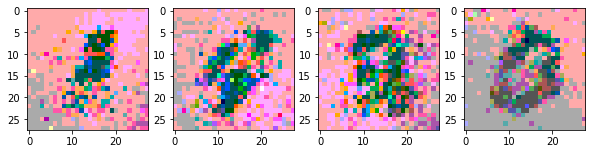

epoch: 9 i: 99 loss: 0.30511146783828735 val loss: 0.3081251084804535
epoch: 9 i: 199 loss: 0.3451087772846222 val loss: 0.3042171597480774
epoch: 9 i: 299 loss: 0.29704079031944275 val loss: 0.3024202585220337
epoch: 9 i: 399 loss: 0.29705366492271423 val loss: 0.3092934191226959
epoch: 9 i: 499 loss: 0.30262887477874756 val loss: 0.30283215641975403
epoch: 9 i: 599 loss: 0.33928003907203674 val loss: 0.3101961314678192


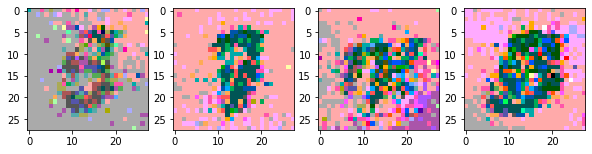

In [22]:
pixelCNN.train(True)
EPOCH = 10
train_loss = []
val_loss = []
j = 0
for epoch in range(EPOCH):
  pixelCNN.train()
  for i, labels in enumerate(trainloader, 0):
    labels = labels.to(device)
    # print("Labels:", labels.shape)
   
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = pixelCNN(labels.float())
    # print("Outout:", outputs.shape)
    loss = criterion(outputs, labels.long())
    
    loss.backward()
    optimizer.step()

    loss = loss.item()
    # print statistics
    j += 1 
    if ((i+1) % 100 == 0):
      with torch.set_grad_enabled(False):
        val_batch = next(iter(testloader))
        val_batch = val_batch.to(device)

        val_output = pixelCNN(val_batch.float())
        val_loss_item = criterion(val_output, val_batch.long()).item()
        val_loss.append(val_loss_item)
      print("epoch:", epoch, "i:" , i, "loss:", loss, "val loss:", val_loss_item)
    train_loss.append(loss)
  sample_image()

Train loss: 


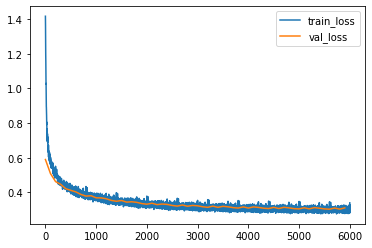

In [23]:
print("Train loss: ")
plt.plot(train_loss, label = "train_loss")
plt.plot(np.arange(0, len(train_loss),int(len(train_loss)/len(val_loss))),val_loss, label = "val_loss")
plt.legend()
plt.show()


In [0]:
# save
torch.save(pixelCNN.state_dict(), 'drive/My Drive/Colab Notebooks/pixel_cnn_made_model')

In [0]:
# load
# pixelCNN = PixelCNN().to(device)
# pixelCNN.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/pixel_cnn_model'))

### 1b

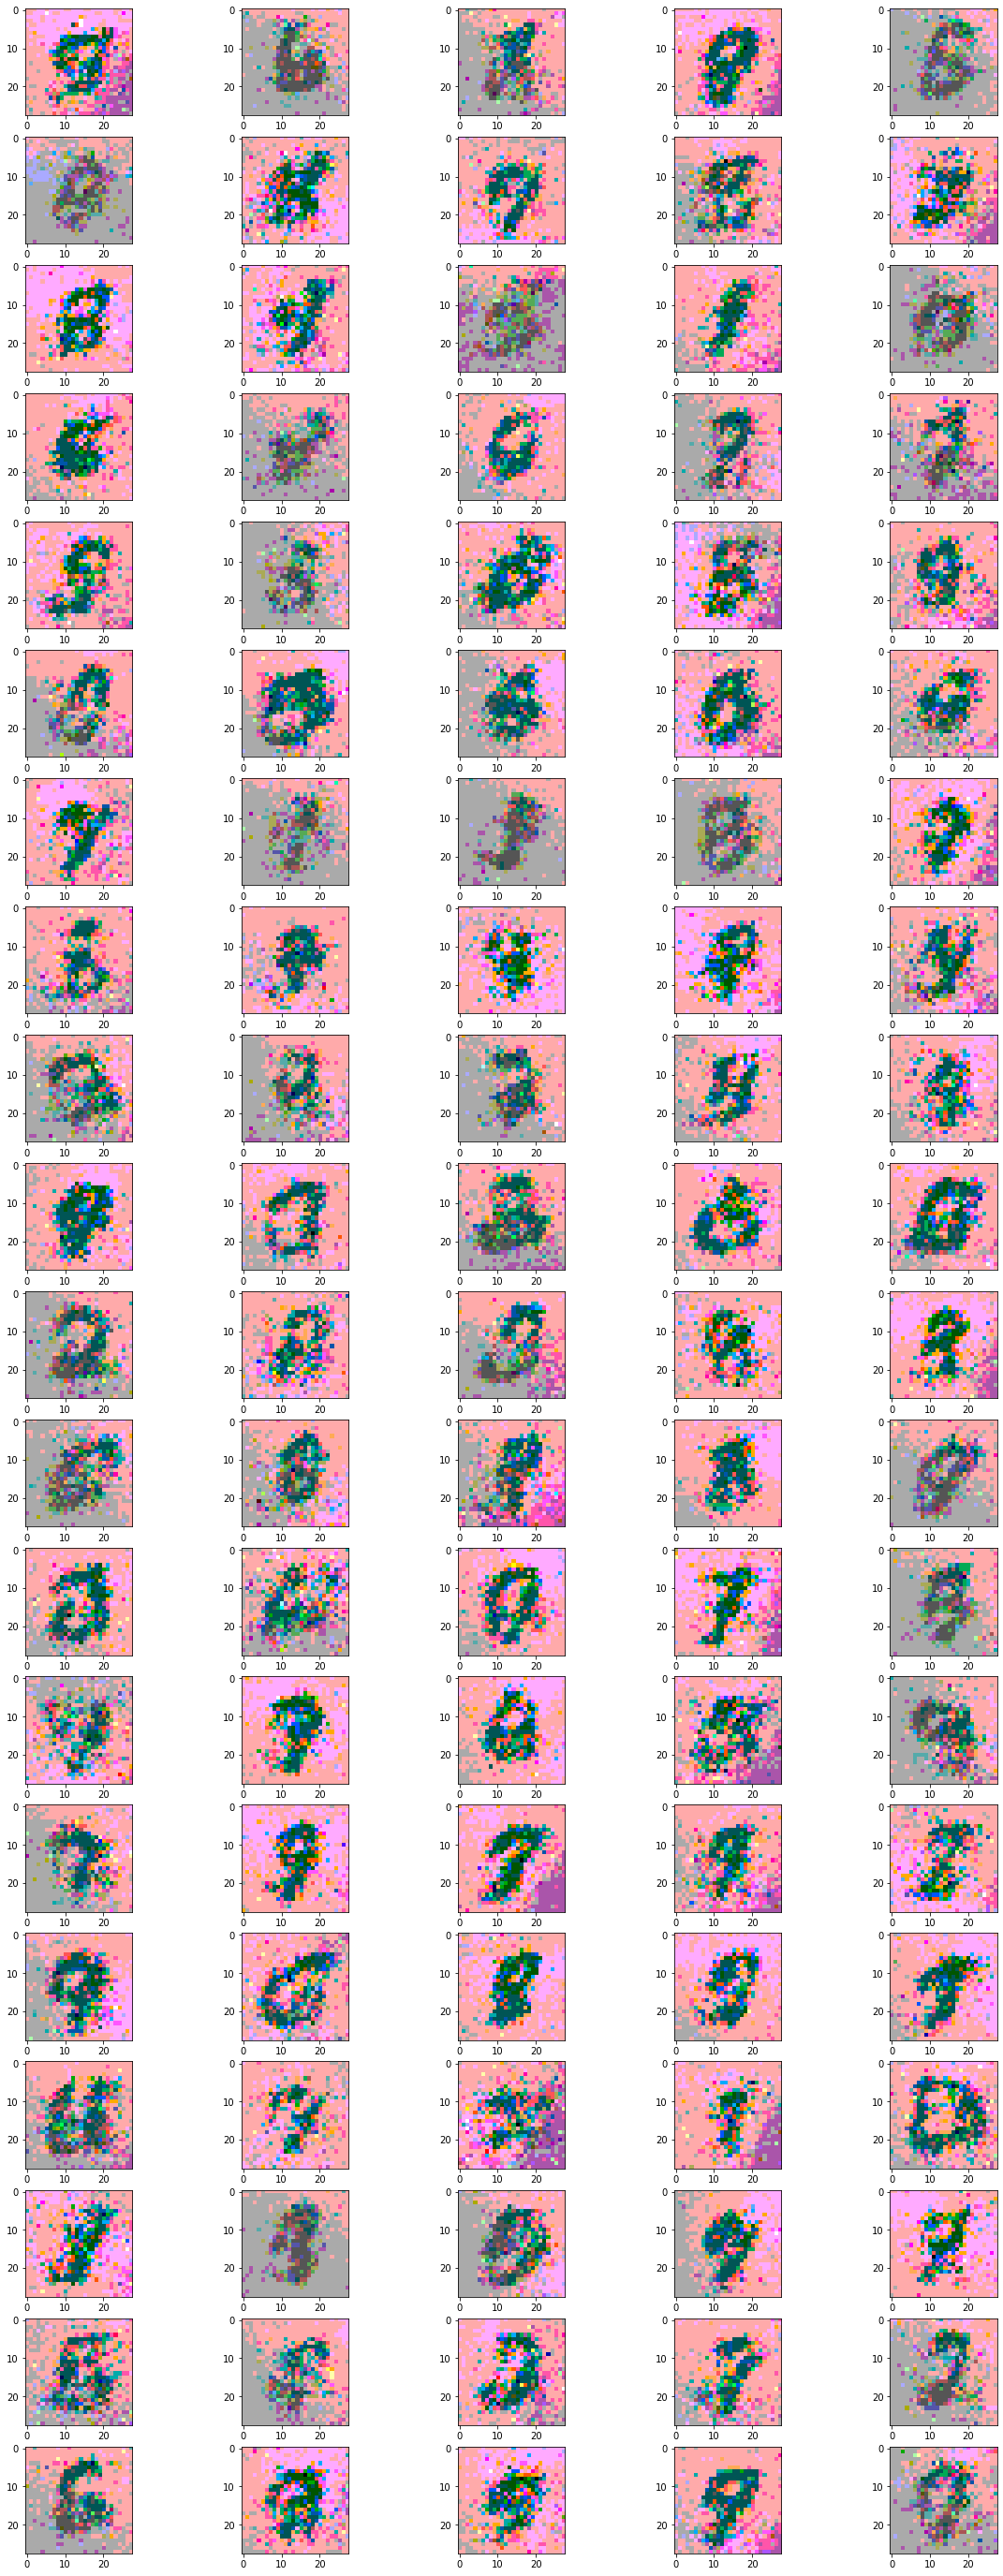

In [26]:
images = sample_image(100)

In [0]:
# Saving images
torchvision.utils.save_image(torch.from_numpy(images).permute(0,3,1,2), 'drive/My Drive/Colab Notebooks/sample.png', nrow=10, padding=0)